In [35]:
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import cv2
from sklearn.decomposition import PCA
from scipy.optimize import least_squares
import math

In [36]:
src_color_image = cv2.imread('data/v2.jpg')
depth_image = np.load('data/v2.npy')

In [37]:
# Преобразование BGR в RGB
src_color_image_rgb = cv2.cvtColor(src_color_image, cv2.COLOR_BGR2RGB)


height, width = src_color_image_rgb.shape[:2]
color_image = np.zeros_like(src_color_image_rgb)

shift_amount = 23
color_image[:, 0 : width - shift_amount] = src_color_image_rgb[:, shift_amount : width]

color_o3d = o3d.geometry.Image(color_image)
depth_o3d = o3d.geometry.Image(depth_image)


rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d,
    depth_o3d,
    depth_scale=1000.0,
    depth_trunc=3.0,
    convert_rgb_to_intensity=False
)


camera_intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=640,
    height=480,
    fx=615.0,
    fy=615.0,
    cx=320.0,
    cy=240.0
)


point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    camera_intrinsics
)

# Поворот облака точек
point_cloud.transform([[1, 0, 0, 0],
                       [0, -1, 0, 0],
                       [0, 0, -1, 0],
                       [0, 0, 0, 1]])


point_cloud, _ = point_cloud.remove_statistical_outlier(
    nb_neighbors=20,
    std_ratio=2.0
)


pcd = point_cloud

print(f"Облако точек создано: {len(pcd.points)} точек")

# Добавление координатных осей для визуализации положения камеры
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1, origin=[0, 0, 0]
)


print("Отображение облака точек...")
o3d.visualization.draw_geometries(
    [pcd, coordinate_frame],
    window_name="Цветное облако точек RealSense",
    width=1024,
    height=768,
    left=50,
    top=50
)

Облако точек создано: 245468 точек
Отображение облака точек...


Должно отобразиться окно:
![color_point_cloud.png](demo/color_point_cloud.png)

# Детектирование ArUco маркера

Найден ArUco маркер с ID: 95
Координаты центра маркера: (318, 269)


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

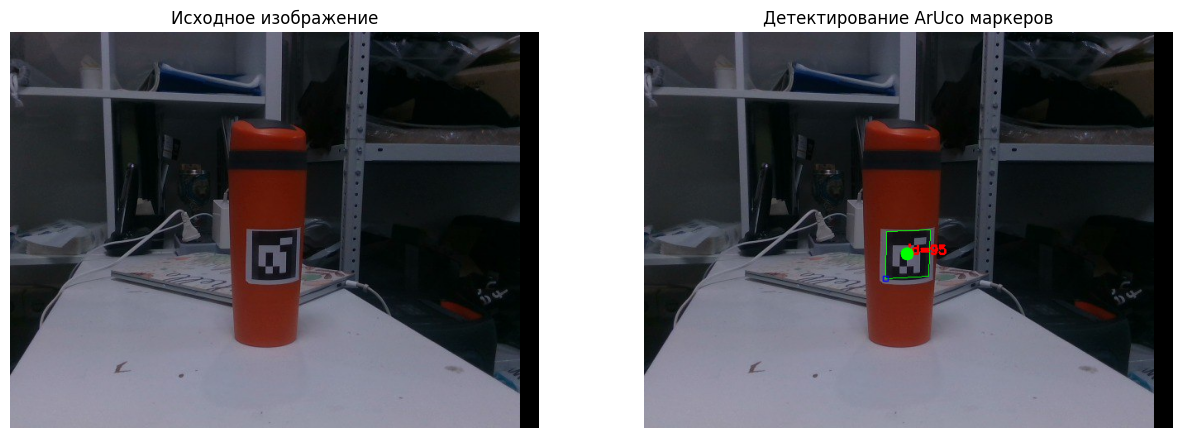

In [38]:
# Детектирование ArUco маркеров
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_MIP_36h12)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

# Конвертация в градации серого для детектирования ArUco
gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
corners, ids, rejected = detector.detectMarkers(gray)


plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(color_image)
plt.title('Исходное изображение')
plt.axis('off')

aruco_image = color_image.copy()
center_point = None

if ids is not None:
    cv2.aruco.drawDetectedMarkers(aruco_image, corners, ids)

    if len(corners) > 0:
        corner_points = corners[0][0]
        center_x = int(np.mean(corner_points[:, 0]))
        center_y = int(np.mean(corner_points[:, 1]))
        center_point = (center_x, center_y)

        cv2.circle(aruco_image, center_point, 8, (0, 255, 0), -1)


        print(f"Найден ArUco маркер с ID: {ids[0][0]}")
        print(f"Координаты центра маркера: {center_point}")
    else:
        print("ArUco маркеры не найдены")
else:
    print("ArUco маркеры не найдены")

plt.subplot(1, 2, 2)
plt.imshow(aruco_image)
plt.title('Детектирование ArUco маркеров')
plt.axis('off')

# Сегментация с помощью Segment Anything Model

Точка для SAM: (318, 220) (на 20 пикселей выше верхней границы маркера)

0: 1024x1024 1 0, 39766.5ms
Speed: 157.2ms preprocess, 39766.5ms inference, 32.8ms postprocess per image at shape (1, 3, 1024, 1024)


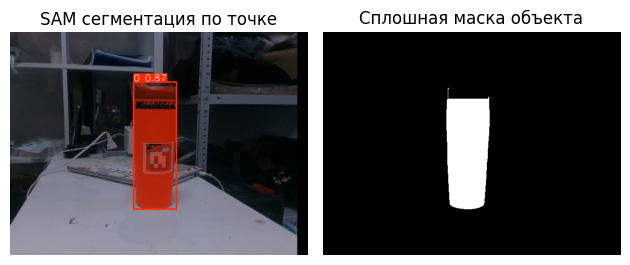

Размер изображения: (480, 640, 3)
Словарь ArUco: ARUCO_MIP_36h12
Количество найденных маркеров: 1
Количество отклоненных кандидатов: 12


In [39]:
# Если ArUco маркер найден, используем SAM для сегментации объекта
if center_point is not None:
    try:
        # Загрузка модели
        from ultralytics import SAM
        sam_model = SAM('sam_b.pt')

        # Вычисляем точку на 10 пикселей выше верхней границы ArUco маркера
        corner_points = corners[0][0]
        top_y = int(np.min(corner_points[:, 1]))
        sam_point = (center_point[0], max(0, top_y - 20))

        print(f"Точка для SAM: {sam_point} (на 20 пикселей выше верхней границы маркера)")


        results = sam_model(color_image, points=[sam_point], labels=[1])

        plt.subplot(1, 2, 1)
        annotated_sam = results[0].plot()
        plt.imshow(annotated_sam)
        plt.title('SAM сегментация по точке')
        plt.axis('off')

        # Получение маски от SAM
        if results[0].masks is not None:
            sam_mask = results[0].masks.data.cpu().numpy()[0]

            # Морфологические операции для получения сплошной маски
            kernel = np.ones((5,5), np.uint8)
            filled_mask = cv2.morphologyEx(sam_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
            filled_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))

            # Альтернативный метод - заполнение контуров
            contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                filled_mask = np.zeros_like(filled_mask)
                cv2.fillPoly(filled_mask, [largest_contour], 1)

            plt.subplot(1, 2, 2)
            plt.imshow(filled_mask, cmap='gray')
            plt.title('Сплошная маска объекта')
            plt.axis('off')


        else:
            print("SAM не смог создать маску для указанной точки")

    except Exception as e:
        print(f"Ошибка при использовании SAM: {e}")

else:
    # Если ArUco не найден
    print("ArUco не найден")

plt.tight_layout()
plt.show()

# Дополнительная информация про ArUco

print(f"Размер изображения: {color_image.shape}")
print(f"Словарь ArUco: ARUCO_MIP_36h12")
print(f"Количество найденных маркеров: {len(ids) if ids is not None else 0}")
if len(rejected) > 0:
    print(f"Количество отклоненных кандидатов: {len(rejected)}")
else:
    print("Кандидаты в маркеры не найдены")

# Проекция маски на точки

In [40]:
# Применяем маску к depth изображению
depth_target_only = depth_image.copy()
depth_target_only[filled_mask == 0] = 0

color_target_only = color_image.copy()
color_target_only[filled_mask == 0] = [0, 0, 0]

# Создаем RGBD изображение для объекта
color_target_o3d = o3d.geometry.Image(color_target_only)
depth_target_o3d = o3d.geometry.Image(depth_target_only)

rgbd_target = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_target_o3d,
    depth_target_o3d,
    depth_scale=1000.0,
    depth_trunc=3.0,
    convert_rgb_to_intensity=False
)

# Создаем облако точек объекта
target_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_target,
    camera_intrinsics
)

# Поворот
target_pcd.transform([[1, 0, 0, 0],
                      [0, -1, 0, 0],
                      [0, 0, -1, 0],
                      [0, 0, 0, 1]])

# Фильтрация выбросов
if len(target_pcd.points) > 20:
    target_pcd, _ = target_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

print(f"Облако точек объекта создано: {len(target_pcd.points)} точек")


print("Отображение облака точек...")

o3d.visualization.draw_geometries(
    [target_pcd, coordinate_frame],
    window_name="Цветное облако точек объекта",
    width=1024,
    height=768,
    left=50,
    top=50
)

Облако точек объекта создано: 19539 точек
Отображение облака точек...
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 


![object_point_cloud.png](demo/object_point_cloud.png)

# Аппроксимируем точки под цилиндр

In [41]:
def fit_cylinder_to_points(points):
    """
    Аппроксимирует облако точек цилиндром.
    """
    if len(points) < 10:
        print("Недостаточно точек для аппроксимации цилиндра (<10)")
        return None

    points = np.array(points)

    # Находим главную ось с помощью PCA
    pca = PCA(n_components=3)
    pca.fit(points)
    axis_pca = pca.components_[0]
    axis_pca = axis_pca / np.linalg.norm(axis_pca)

    # Центроид облака точек
    center_centroid = np.mean(points, axis=0)

    # Создаем ортонормированный базис для плоскости, перпендикулярной оси PCA
    if abs(np.dot(axis_pca, np.array([0, 0, 1]))) < 0.98:
        v1 = np.cross(axis_pca, [0, 0, 1])
    else:
        v1 = np.cross(axis_pca, [1, 0, 0])

    if np.linalg.norm(v1) < 1e-6:
        v1 = np.cross(axis_pca, [0, 1, 0])
        if np.linalg.norm(v1) < 1e-6:
            print("Не удалось определить хороший перпендикулярный вектор")
            return None

    v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(axis_pca, v1)
    v2 = v2 / np.linalg.norm(v2)

    # Проецируем точки на плоскость
    points_centered_on_centroid = points - center_centroid
    proj_coords_v1 = np.dot(points_centered_on_centroid, v1)
    proj_coords_v2 = np.dot(points_centered_on_centroid, v2)
    points_2d_in_plane = np.vstack((proj_coords_v1, proj_coords_v2)).T

    if len(points_2d_in_plane) < 3:
        print("Недостаточно точек для fit_circle_2d (<3)")
        return None

    # Подгоняем окружность к 2D проекциям
    cx_plane, cy_plane, radius_fit = fit_circle_2d(points_2d_in_plane)

    if radius_fit is None:
        print("fit_circle_2d failed to converge.")
        return None

    print(f"  Fit_circle_2d results: offset_x_in_plane={cx_plane:.4f}, offset_y_in_plane={cy_plane:.4f}, radius={radius_fit:.4f}")

    # Скорректированная точка на оси цилиндра
    offset_from_centroid_in_plane = cx_plane * v1 + cy_plane * v2
    axis_point_corrected = center_centroid + offset_from_centroid_in_plane

    final_axis_direction = axis_pca

    # Находим высоту цилиндра
    points_relative_to_axis_point = points - axis_point_corrected
    proj_z_on_axis = np.dot(points_relative_to_axis_point, final_axis_direction)

    min_z_proj = np.min(proj_z_on_axis)
    max_z_proj = np.max(proj_z_on_axis)
    height_fit = max_z_proj - min_z_proj

    # Финальный геометрический центр цилиндра
    center_geometric = axis_point_corrected + final_axis_direction * (min_z_proj + max_z_proj) / 2.0

    print(f"Параметры цилиндра (уточненная ось):")
    print(f"  Исходный центроид облака: {center_centroid}")
    print(f"  Смещение центра сечения в плоскости (v1,v2): {offset_from_centroid_in_plane}")
    print(f"  Скорректированная точка на оси: {axis_point_corrected}")
    print(f"  Направление оси цилиндра (PCA): {final_axis_direction}")
    print(f"  Проекции точек на скорр. ось (min, max относительно axis_point_corrected): {min_z_proj:.4f}, {max_z_proj:.4f}")
    print(f"  Итоговый геометрический центр цилиндра: {center_geometric}")
    print(f"  Радиус (из 2D окружности): {radius_fit:.4f}")
    print(f"  Высота: {height_fit:.4f}")

    if radius_fit <= 1e-3 or height_fit <= 1e-3:
        print(f"Warning: Degenerate cylinder parameters (R={radius_fit:.4f}, H={height_fit:.4f}).")
        return None

    return {
        'center': center_geometric,
        'axis': final_axis_direction,
        'radius': radius_fit,
        'height': height_fit,
        'v1': v1,
        'v2': v2
    }



def fit_circle_2d(points_2d):
    """
    Подгоняет окружность к 2D точкам методом наименьших квадратов.
    points_2d: Nx2 numpy массив (x, y)
    Возвращает: (center_x, center_y, radius)
    """
    x_coords = points_2d[:, 0]
    y_coords = points_2d[:, 1]

    def residuals(params, x, y):
        xc, yc, r_sq = params # Оптимизируем для r_squared
        return (x - xc)**2 + (y - yc)**2 - r_sq

    # Начальное предположение
    x_m = np.mean(x_coords)
    y_m = np.mean(y_coords)
    r_sq_m = np.median((x_coords - x_m)**2 + (y_coords - y_m)**2)

    # Защита от нулевого или отрицательного начального r_sq
    if r_sq_m <= 1e-8:
        r_sq_m = 1e-8

    initial_guess = [x_m, y_m, r_sq_m]

    # Ограничения: r_sq должен быть положительным
    res = least_squares(residuals, initial_guess, args=(x_coords, y_coords), method='trf',
                        bounds=([-np.inf, -np.inf, 1e-8], [np.inf, np.inf, np.inf]))

    if not res.success:
        print(f"Warning: fit_circle_2d optimization failed. Status: {res.status}, Message: {res.message}")
        return None, None, None

    xc, yc, r_sq_opt = res.x
    radius = np.sqrt(abs(r_sq_opt))
    return xc, yc, radius



print("Подгонка цилиндра к точкам объекта...")

if len(target_pcd.points) < 10:
    print("Недостаточно точек объекта для аппроксимации цилиндром (<10).")
    cylinder_params = None
    cylinder_mesh = None
else:
    target_points_np = np.asarray(target_pcd.points)
    print(f"Количество точек для подгонки: {len(target_points_np)}")

    # Подгоняем цилиндр
    cylinder_params = fit_cylinder_to_points(target_points_np)




Подгонка цилиндра к точкам объекта...
Количество точек для подгонки: 19539
  Fit_circle_2d results: offset_x_in_plane=0.0003, offset_y_in_plane=0.0277, radius=0.0337
Параметры цилиндра (уточненная ось):
  Исходный центроид облака: [ -0.0083539   -0.014036    -0.46444]
  Смещение центра сечения в плоскости (v1,v2): [ 0.00034141   0.0046893   -0.027297]
  Скорректированная точка на оси: [ -0.0080125  -0.0093467    -0.49174]
  Направление оси цилиндра (PCA): [   0.012885     0.98546     0.16945]
  Проекции точек на скорр. ось (min, max относительно axis_point_corrected): -0.0930, 0.1005
  Итоговый геометрический центр цилиндра: [ -0.0079642  -0.0056585    -0.49111]
  Радиус (из 2D окружности): 0.0337
  Высота: 0.1935


In [42]:
def create_cylinder_mesh(cylinder_params, resolution=30, color=None):
    """
    Создает меш цилиндра по параметрам
    """
    if cylinder_params is None:
        return None

    center = cylinder_params['center']
    axis_z = cylinder_params['axis']
    radius = cylinder_params['radius']
    height = cylinder_params['height']
    axis_x = cylinder_params['v1']
    axis_y = cylinder_params['v2']

    # Проверка на вырожденные параметры
    if radius <= 1e-4 or height <= 1e-4:
        print(f"Skipping cylinder mesh creation due to zero/small radius ({radius:.4f}) or height ({height:.4f}).")
        return None

    # Создаем базовый цилиндр
    cylinder = o3d.geometry.TriangleMesh.create_cylinder(
        radius=radius,
        height=height,
        resolution=resolution,
        split=4
    )

    # Создаем матрицу поворота
    rotation_matrix = np.eye(3)
    rotation_matrix[:, 0] = axis_x
    rotation_matrix[:, 1] = axis_y
    rotation_matrix[:, 2] = axis_z

    # Создаем матрицу трансформации
    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = rotation_matrix
    transform_matrix[:3, 3] = center

    # Применяем трансформацию
    cylinder.transform(transform_matrix)

    # Окрашиваем цилиндр
    if color is None:
        color = [0.2, 0.5, 0.8]
    cylinder.paint_uniform_color(color)

    return cylinder


cylinder_mesh = create_cylinder_mesh(cylinder_params)

In [43]:
print("Создание сцены без объекта...")

# Создаем depth изображение без объекта
depth_without_target = depth_image.copy()
depth_without_target[filled_mask > 0] = 0

# Создаем цветное изображение без объекта
color_without_target = color_image.copy()
color_without_target[filled_mask > 0] = [0, 0, 0]

# Создаем RGBD изображение для сцены без объекта
color_scene_o3d = o3d.geometry.Image(color_without_target)
depth_scene_o3d = o3d.geometry.Image(depth_without_target)

rgbd_scene = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_scene_o3d,
    depth_scene_o3d,
    depth_scale=1000.0,
    depth_trunc=3.0,
    convert_rgb_to_intensity=False
)

# Создаем облако точек сцены
scene_pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_scene,
    camera_intrinsics
)

# Поворот облака точек
scene_pcd.transform([[1, 0, 0, 0],
                     [0, -1, 0, 0],
                     [0, 0, -1, 0],
                     [0, 0, 0, 1]])

# Фильтрация выбросов
if len(scene_pcd.points) > 20:
    scene_pcd, _ = scene_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

print(f"Облако точек сцены без объекта создано: {len(scene_pcd.points)} точек")


Создание сцены без объекта...
Облако точек сцены без объекта создано: 226201 точек


In [44]:
# Визуализация
print("Визуализация облака точек объекта и подогнанный цилиндр")

geometries_mode1 = []

if target_pcd and len(target_pcd.points) > 0:
    target_pcd.paint_uniform_color([1.0, 0.7, 0.0])  # Оранжевый
    geometries_mode1.append(target_pcd)

if cylinder_mesh:
    geometries_mode1.append(cylinder_mesh)

if geometries_mode1:
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    geometries_mode1.append(coordinate_frame)

    o3d.visualization.draw_geometries(
        geometries_mode1,
        window_name="Визуализация облака точек объекта и подогнанный цилиндр",
        width=1024, height=768, left=50, top=50
    )
else:
    print("Нечего отображать.")

Визуализация облака точек объекта и подогнанный цилиндр


![demo/cylinder_approximation.png](demo/cylinder_approximation.png)

In [45]:
# (Сцена с цилиндром)
print("Полная сцена с цилиндром вместо объекта")

geometries_mode2 = []
if scene_pcd and len(scene_pcd.points) > 0:
    geometries_mode2.append(scene_pcd)

if cylinder_mesh:
    geometries_mode2.append(cylinder_mesh)

if geometries_mode2:
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    geometries_mode2.append(coordinate_frame)

    print("Отображение: Сцена с цилиндром")
    o3d.visualization.draw_geometries(
        geometries_mode2,
        window_name="Сцена с цилиндром",
        width=1024, height=768, left=150, top=150
    )
else:
    print("Нечего отображать")

Полная сцена с цилиндром вместо объекта
Отображение: Сцена с цилиндром


![demo/cylinder_and_point_cloud.png](demo/cylinder_and_point_cloud.png)

In [46]:
# Сохранение результатов (опционально)
save_results = input("\nСохранить результаты? (y/n): ")
if save_results.lower() == 'y':
    if scene_pcd and len(scene_pcd.points) > 0:
        o3d.io.write_point_cloud("scene_without_target.ply", scene_pcd)
        print("Сцена без объекта сохранена как 'scene_without_target.ply'")

    if cylinder_mesh:
        o3d.io.write_triangle_mesh("target_cylinder.ply", cylinder_mesh)
        print("Цилиндр объекта сохранен как 'target_cylinder.ply'")

    if target_pcd and len(target_pcd.points) > 0:
        o3d.io.write_point_cloud("target_segmented_pcd.ply", target_pcd)
        print("Сегментированное облако точек объекта сохранено как 'target_segmented_pcd.ply'")
